## Preprocess data

In [1]:
import pandas as pd
import numpy as np
import os

# define data directory
data_dir = os.path.pardir + os.sep + 'data' + os.sep + 'raw'

# define country lookup file path
country_lookup_file = data_dir + os.sep + 'country_latitude_longitude_area_lookup.csv'

# define yield file path
yield_file = data_dir + os.sep + 'Yield_and_Production_data.csv'

# define landcover file path
land_cover_file = data_dir + os.sep + 'Land_cover_percent_data.csv'

country_data = pd.read_csv(country_lookup_file) # read into a dataframe
yield_data = pd.read_csv(yield_file)

env_files = [
    data_dir + os.sep + 'SoilMoi0_10cm_inst_data.csv',
    data_dir + os.sep + 'SoilMoi10_40cm_inst_data.csv',
    data_dir + os.sep + 'SoilMoi40_100cm_inst_data.csv',
    data_dir + os.sep + 'SoilMoi100_200cm_inst_data.csv',
    data_dir + os.sep + 'SoilTMP0_10cm_inst_data.csv',
    data_dir + os.sep + 'SoilTMP10_40cm_inst_data.csv',
    data_dir + os.sep + 'SoilTMP40_100cm_inst_data.csv',
    data_dir + os.sep + 'SoilTMP100_200cm_inst_data.csv',
    data_dir + os.sep + 'Rainf_tavg_data.csv',
    data_dir + os.sep + 'Snowf_tavg_data.csv',
    data_dir + os.sep + 'TVeg_tavg_data.csv',
    data_dir + os.sep + 'TWS_inst_data.csv',
    data_dir + os.sep + 'CanopInt_inst_data.csv',
    data_dir + os.sep + 'ESoil_tavg_data.csv',
    data_dir + os.sep + 'Land_cover_percent_data.csv',
]

In [2]:
from sklearn.neighbors import NearestNeighbors
import math

# this function takes a dataframe with monthly columns
# and convert these columns into yearly summaries
# using the functions defined by `agg_functions`
def aggregate_monthly_into_year_columns(var_name, df, agg_functions):
    # Take a copy of the dataframe
    df = df.copy()

    month_cols = [col for col in df.columns if 'month' in col]

    # Define functions for aggregation
    funcs = {
        'mean': lambda x: x.mean(axis=1), 
        'max': lambda x: x.max(axis=1),
        'min': lambda x: x.min(axis=1),
        'std': lambda x: x.std(axis=1),
    }

    if month_cols:
        for fun in agg_functions:
            df[f'{var_name}_{fun}'] = funcs[fun](df[month_cols])
        
        df = df.drop(month_cols, axis=1) # drop month columns
    else:
        print(f"No Month Columns in {var_name}")
    return df

In [3]:
# this function takes the file path and extract a var name
# this var name is used for later steps, then the function
# reads the file into a datafram and checks for any missing values
# then using linear interpolation to fill them.

def handle_missing_values_by_interpolation(file_path):
    var_name = "_".join(file_path.split('_')[:2]).split(os.sep)[-1]
    df = pd.read_csv(file_path)
    if df.isnull().sum().values.any():
        print(f"Missing Values Exist for {var_name}. Handling it using Linear Interpolation...")
        month_cols = [col for col in df.columns if 'month' in col]
        df[month_cols] = df[month_cols].interpolate(method='linear', axis=1)
    else:
        print(f"No Missing Values for {var_name}")
    
    return var_name, df

In [4]:
# this function takes both a df and the df containing
# country data and maps each latitude and longitude
# in the dataframe to a country then drops the latitude and logitude cols

def map_to_country(df, country_data):
    valid_country_data = country_data.dropna(subset=['centroid latitude', 'centroid longitude']).copy()
    
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(
        valid_country_data[['centroid latitude', 'centroid longitude']].values
    )
    distances, indices = nbrs.kneighbors(df[['latitude', 'longitude']].values)
    df['country'] = valid_country_data.iloc[indices.flatten()]['country'].values

    df = df.drop(['longitude', 'latitude'], axis=1)
    return df

In [5]:
def process_environmental_data(file_path, country_data):
    print(f'Processing {file_path}...')
    var_name, df = handle_missing_values_by_interpolation(file_path)
    
    # monthly to year summaries
    df = aggregate_monthly_into_year_columns(var_name, df, ['mean', 'max', 'min', 'std'])

    # lat and lon data to nearset country centroid
    df_stats = map_to_country(df, country_data)
    
    # group by country and year, then get mean
    country_agg = df_stats.groupby(['country', 'year']).mean().reset_index()

    return var_name, country_agg

In [6]:
processed_env_data = {}

for file in env_files[:-1]:
    var_name, data = process_environmental_data(file, country_data)
    processed_env_data[var_name] = data

Processing ../data/raw/SoilMoi0_10cm_inst_data.csv...
No Missing Values for SoilMoi0_10cm
Processing ../data/raw/SoilMoi10_40cm_inst_data.csv...
No Missing Values for SoilMoi10_40cm
Processing ../data/raw/SoilMoi40_100cm_inst_data.csv...
No Missing Values for SoilMoi40_100cm
Processing ../data/raw/SoilMoi100_200cm_inst_data.csv...
Missing Values Exist for SoilMoi100_200cm. Handling it using Linear Interpolation...
Processing ../data/raw/SoilTMP0_10cm_inst_data.csv...
No Missing Values for SoilTMP0_10cm
Processing ../data/raw/SoilTMP10_40cm_inst_data.csv...
No Missing Values for SoilTMP10_40cm
Processing ../data/raw/SoilTMP40_100cm_inst_data.csv...
No Missing Values for SoilTMP40_100cm
Processing ../data/raw/SoilTMP100_200cm_inst_data.csv...
No Missing Values for SoilTMP100_200cm
Processing ../data/raw/Rainf_tavg_data.csv...
No Missing Values for Rainf_tavg
Processing ../data/raw/Snowf_tavg_data.csv...
No Missing Values for Snowf_tavg
Processing ../data/raw/TVeg_tavg_data.csv...
No Miss

In [7]:
# this function handles the land cover data specifically
# because it is has different features from the other data files
# it maps the country data and fix the column names

def handle_land_cover_data(file_path):
    # extract var name
    var_name = "_".join(file_path.split('_')[:2])

    # read as df
    df = pd.read_csv(file_path)
    
    # map to country
    df = map_to_country(df, country_data)
    
    # group by country and year
    df = df.groupby(['country', 'year']).mean().reset_index()

    # fix namings
    df.columns = ['country', 'year'] + [f'Land_cover_percent_class_{i}_mean' for i in range(1, 18)]

    return var_name, df

lc_var_name, lc_data = handle_land_cover_data(land_cover_file)

processed_env_data[lc_var_name] = lc_data

In [8]:
def merge_env_data(env_data):
    dfs = list(env_data.values())
    
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on=['country','year'], how='outer')

    merged_df = merged_df.dropna()
    # merged_df.to_csv('./processed_data/merged_data.csv')

    return merged_df

mergeddf = merge_env_data(processed_env_data)
mergeddf

,country,year,SoilMoi0_10cm_mean,SoilMoi0_10cm_max,SoilMoi0_10cm_min,SoilMoi0_10cm_std,SoilMoi10_40cm_mean,SoilMoi10_40cm_max,SoilMoi10_40cm_min,SoilMoi10_40cm_std,...,Land_cover_percent_class_8_mean,Land_cover_percent_class_9_mean,Land_cover_percent_class_10_mean,Land_cover_percent_class_11_mean,Land_cover_percent_class_12_mean,Land_cover_percent_class_13_mean,Land_cover_percent_class_14_mean,Land_cover_percent_class_15_mean,Land_cover_percent_class_16_mean,Land_cover_percent_class_17_mean
0,Afghanistan,2010,16.522271,28.206306,10.271846,6.082935,67.114595,83.597542,60.056409,7.501144,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,Afghanistan,2011,17.474098,29.795020,9.869525,6.565297,67.260410,84.420864,58.892841,7.851925,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,Afghanistan,2012,17.885093,31.241178,10.574864,6.973433,68.767602,87.565758,61.072146,8.219436,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,Afghanistan,2013,18.206896,30.001290,10.339432,6.946152,68.528548,84.722359,60.286163,7.793965,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,Afghanistan,2014,17.882212,27.558367,9.866665,6.103947,68.116610,82.573003,60.452112,6.681026,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,Zimbabwe,2018,16.033562,27.563827,8.738126,6.342460,51.977643,78.619991,36.450053,15.253257,...,0.0,0.0,0.0,0.108108,0.0,0.0,0.0,0.0,0.0,99.891892
3142,Zimbabwe,2019,13.997708,23.740387,8.255156,5.279857,41.318247,70.207207,27.374871,15.237694,...,0.0,0.0,0.0,0.135135,0.0,0.0,0.0,0.0,0.0,99.864865
3143,Zimbabwe,2020,16.126469,24.766616,9.118769,5.708984,50.115415,72.296331,35.592977,13.469059,...,0.0,0.0,0.0,0.189189,0.0,0.0,0.0,0.0,0.0,99.810811
3144,Zimbabwe,2021,14.270586,25.760141,8.354199,6.042134,40.861896,74.400733,27.597889,16.761634,...,0.0,0.0,0.0,0.270270,0.0,0.0,0.0,0.0,0.0,99.729730


In [9]:
def process_yield_data():
    # filter for yield only values
    valid_yield_data = yield_data[yield_data['Element'] == 'Yield']

    # drop unnecessary columns
    valid_yield_data = valid_yield_data.drop(['Domain', 'Item Code (CPC)', 'Flag', 'Element'], axis=1)

    # rename columns to be prepared for merge later
    df = valid_yield_data.rename(columns={"Value": "yield", "Country": "country", "Year": "year"})

    # sum up all the yield for all items
    df = df.groupby(['country', 'year'])['yield'].sum().reset_index()

    # get target yield column
    df["target_yield"] = df.groupby(["country"])["yield"].shift(-1)

    # drop all the missing rows in target_yield column
    df = df.dropna(subset=["target_yield"])

    # cast values in Yield and target_yield values to int
    df['target_yield'] = df['target_yield'].astype(int)

    return df
yielddata = process_yield_data()

In [10]:
yielddata

,country,year,yield,target_yield
0,Afghanistan,2010,202096.9,198491
1,Afghanistan,2011,198491.8,200353
2,Afghanistan,2012,200353.1,207231
3,Afghanistan,2013,207231.9,202590
4,Afghanistan,2014,202590.8,177158
...,...,...,...,...
2579,Zimbabwe,2017,246771.5,252597
2580,Zimbabwe,2018,252597.7,249564
2581,Zimbabwe,2019,249564.1,252611
2582,Zimbabwe,2020,252611.0,252387


In [11]:
def final_merge(c_y_data, merged_df):
    # merge yield data with environmental data: prioritize env
    merged = pd.merge(c_y_data, merged_df, on=["country", "year"], how="right")

    # drop rows where yield value is absent
    merged = merged.dropna(subset=['target_yield', 'yield']).reset_index(drop=True)

    # save file
    # merged.to_csv('./processed_data/merged_data.csv')
    return merged

merged_df = final_merge(yielddata, mergeddf)
merged_df.head()

,country,year,yield,target_yield,SoilMoi0_10cm_mean,SoilMoi0_10cm_max,SoilMoi0_10cm_min,SoilMoi0_10cm_std,SoilMoi10_40cm_mean,SoilMoi10_40cm_max,...,Land_cover_percent_class_8_mean,Land_cover_percent_class_9_mean,Land_cover_percent_class_10_mean,Land_cover_percent_class_11_mean,Land_cover_percent_class_12_mean,Land_cover_percent_class_13_mean,Land_cover_percent_class_14_mean,Land_cover_percent_class_15_mean,Land_cover_percent_class_16_mean,Land_cover_percent_class_17_mean
0,Afghanistan,2010,202096.9,198491.0,16.522271,28.206306,10.271846,6.082935,67.114595,83.597542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,2011,198491.8,200353.0,17.474098,29.795020,9.869525,6.565297,67.260410,84.420864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,2012,200353.1,207231.0,17.885093,31.241178,10.574864,6.973433,68.767602,87.565758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,2013,207231.9,202590.0,18.206896,30.001290,10.339432,6.946152,68.528548,84.722359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,2014,202590.8,177158.0,17.882212,27.558367,9.866665,6.103947,68.116610,82.573003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature selection based on correlation and MI

In [12]:
raw_df = merged_df.copy()
raw_df = raw_df.drop(columns=['country', 'year'])

In [13]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

X = raw_df.drop(columns=["target_yield"])
y = raw_df["target_yield"]

# compute mutual information scores
mi_scores = mutual_info_regression(X, y, discrete_features='auto')
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# select features based on the MI threshold = 0.5
mi_selected = mi_series[mi_series > 0.5].index.tolist()

# compute Spearman correlation
correlations = raw_df.corr(method='spearman')["target_yield"]
corr_selected = correlations[correlations.abs() > 0.2].index.tolist()

# MI + correlation selections
selected_features = list(set(mi_selected) | set(corr_selected))

# Ensure 'year' and 'country' are included
for col in ['year', 'country']:
    if col not in selected_features:
        selected_features.append(col)

# Build reduced dataset
reduced_df = merged_df[selected_features].copy()

In [14]:
merged_df

,country,year,yield,target_yield,SoilMoi0_10cm_mean,SoilMoi0_10cm_max,SoilMoi0_10cm_min,SoilMoi0_10cm_std,SoilMoi10_40cm_mean,SoilMoi10_40cm_max,...,Land_cover_percent_class_8_mean,Land_cover_percent_class_9_mean,Land_cover_percent_class_10_mean,Land_cover_percent_class_11_mean,Land_cover_percent_class_12_mean,Land_cover_percent_class_13_mean,Land_cover_percent_class_14_mean,Land_cover_percent_class_15_mean,Land_cover_percent_class_16_mean,Land_cover_percent_class_17_mean
0,Afghanistan,2010,202096.9,198491.0,16.522271,28.206306,10.271846,6.082935,67.114595,83.597542,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,Afghanistan,2011,198491.8,200353.0,17.474098,29.795020,9.869525,6.565297,67.260410,84.420864,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,Afghanistan,2012,200353.1,207231.0,17.885093,31.241178,10.574864,6.973433,68.767602,87.565758,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,Afghanistan,2013,207231.9,202590.0,18.206896,30.001290,10.339432,6.946152,68.528548,84.722359,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,Afghanistan,2014,202590.8,177158.0,17.882212,27.558367,9.866665,6.103947,68.116610,82.573003,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,Zimbabwe,2017,246771.5,252597.0,17.982619,28.646438,8.590517,7.052056,59.075482,85.755510,...,0.0,0.0,0.0,0.135135,0.0,0.0,0.0,0.0,0.0,99.864865
1974,Zimbabwe,2018,252597.7,249564.0,16.033562,27.563827,8.738126,6.342460,51.977643,78.619991,...,0.0,0.0,0.0,0.108108,0.0,0.0,0.0,0.0,0.0,99.891892
1975,Zimbabwe,2019,249564.1,252611.0,13.997708,23.740387,8.255156,5.279857,41.318247,70.207207,...,0.0,0.0,0.0,0.135135,0.0,0.0,0.0,0.0,0.0,99.864865
1976,Zimbabwe,2020,252611.0,252387.0,16.126469,24.766616,9.118769,5.708984,50.115415,72.296331,...,0.0,0.0,0.0,0.189189,0.0,0.0,0.0,0.0,0.0,99.810811


## Data Splitting

In [15]:
# Sort and prepare data
merged_df = reduced_df.sort_values("year")

# Split by year 2017
split_year = 2017

# Define features and target
feature_cols = [col for col in merged_df.columns if col not in ["country", "year", "target_yield"]]
target_col = "target_yield"

# Create feature matrices and target vectors
X_train = merged_df[merged_df["year"] <= split_year][feature_cols]
y_train = merged_df[merged_df["year"] <= split_year][target_col]

X_test = merged_df[merged_df["year"] > split_year][feature_cols]
y_test = merged_df[merged_df["year"] > split_year][target_col]

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (1318, 25) X_test: (660, 25)


# Scale Train and Test Data

This step envolves using `StandardScaler` to scale the train and test data

In [69]:
# imports 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [70]:
# Now split the train data to train and validation sets. 
# This allows for unbiased hyperparameter tuning and early stopping for training
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=291158
)

feature_scaler = StandardScaler().fit(X_train_split)

X_train_scaled = feature_scaler.transform(X_train_split)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = StandardScaler().fit(y_train_split.values.reshape(-1, 1))

y_train_scaled = target_scaler.transform(y_train_split.values.reshape(-1, 1))
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

## Apply PCA to reduce dimensionality

In [115]:
from sklearn.decomposition import PCA

# this keeps 95% of the variance
pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original count:", X_train_scaled.shape[1])
print("Reduced count:", X_train_pca.shape[1])

Original count: 25
Reduced count: 7


# MLP model

In the next cell I am building a modular design for the MLP to accept different configuration. This will allow for later tests using grid search.

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YieldMLP(nn.Module):
    def __init__(self, input_size, h1, h2, h3, dropout=0.1, bn=False):
        super(YieldMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        
        self.fc3 = nn.Linear(h2, h3)
        self.bn3 = nn.BatchNorm1d(h3)
        
        self.fc4 = nn.Linear(h3, 1)
        self.dropout = nn.Dropout(dropout)

        self.bn = bn

    def forward(self, x):
        if self.bn:
            x = F.relu(self.bn1(self.fc1(x)))
            x = self.dropout(x)
            x = F.relu(self.bn2(self.fc2(x)))
            x = self.dropout(x)
            x = F.relu(self.bn3(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
            x = F.relu(self.fc3(x))
            x = self.fc4(x)
        return x

In [29]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import random

def set_seed(seed=291158):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
set_seed()

In [30]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Set seed for reproducible
g = torch.Generator()
g.manual_seed(291158)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Optimize Hyperparameters

In [135]:
def experiment_full_grid(epochs):
    architectures = [
        (512, 256, 128),
        (256, 128, 64),
        (128, 64, 32),
        (64, 32, 16)]
    learning_rates = [1e-3, 5e-4, 1e-4]
    dropout_rates = [0.0, 0.1, 0.2, 0.3]
    batchnorm_options = [True, False]
    weight_decays = [0.0, 1e-6, 1e-5, 1e-4]

    best_overall = float('inf')
    best_config = None
    results = []

    set_seed()

    for arch in architectures:
        h1, h2, h3 = arch
        for lr in learning_rates:
            for dr in dropout_rates:
                for bn in batchnorm_options:
                    for wd in weight_decays:
                        model = YieldMLP(
                            input_size=X_train_tensor.shape[1],
                            h1=h1, h2=h2, h3=h3,
                            dropout=dr, bn=bn
                        ).to(device)

                        criterion = nn.MSELoss()
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

                        best_val_loss = float('inf')
                        patience = np.round(epochs*0.2)
                        wait = 0

                        for epoch in range(epochs):
                            model.train()
                            for X_batch, y_batch in train_loader:
                                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                                optimizer.zero_grad()
                                outputs = model(X_batch)
                                loss = criterion(outputs, y_batch)
                                loss.backward()
                                optimizer.step()

                            model.eval()
                            val_loss = 0.0
                            with torch.no_grad():
                                for X_val_batch, y_val_batch in val_loader:
                                    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                                    val_outputs = model(X_val_batch)
                                    val_loss += criterion(val_outputs, y_val_batch).item() * X_val_batch.size(0)

                            val_loss /= len(val_loader.dataset)

                            if val_loss < best_val_loss:
                                best_val_loss = val_loss
                                wait = 0
                            else:
                                wait += 1
                                if wait >= patience:
                                    break

                        results.append({
                            "architecture": arch,
                            "lr": lr,
                            "dropout": dr,
                            "batchnorm": bn,
                            "weight_decay": wd,
                            "best_val_loss": best_val_loss
                        })

                        if best_val_loss < best_overall:
                            best_overall = best_val_loss
                            best_config = results[-1]
                            print(f"New best: {best_config}")

    print("Grid search complete.")
    return best_config, results

In [136]:
best_config, results = experiment_full_grid(100)

New best: {'architecture': (512, 256, 128), 'lr': 0.001, 'dropout': 0.0, 'batchnorm': True, 'weight_decay': 0.0, 'best_val_loss': 0.021824957125566223}
New best: {'architecture': (256, 128, 64), 'lr': 0.001, 'dropout': 0.1, 'batchnorm': True, 'weight_decay': 0.0001, 'best_val_loss': 0.020694899316312687}
New best: {'architecture': (64, 32, 16), 'lr': 0.0005, 'dropout': 0.0, 'batchnorm': True, 'weight_decay': 1e-05, 'best_val_loss': 0.02063478393988176}
Grid search complete.


In [137]:
print("Best Configuration:")
print(f"Best Architecture: {best_config['architecture']}")
print(f"Learning Rate:     {best_config['lr']}")
print(f"Dropout:           {best_config['dropout']}")
print(f"Batch Norm:        {best_config['batchnorm']}")
print(f"Weight Decay:      {best_config['weight_decay']}")
print(f"Best Validation Loss: {best_config['best_val_loss']:.6f}")

Best Configuration:
Best Architecture: (64, 32, 16)
Learning Rate:     0.0005
Dropout:           0.0
Batch Norm:        True
Weight Decay:      1e-05
Best Validation Loss: 0.020635


## Build Model Using the chosen Hyperparameters

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# init model
model = YieldMLP(input_size=X_train_tensor.shape[1], h1=64, h2=32, h3=16, dropout=0.0, bn=True).to(device)

# init Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-05)

# define number of training epochs
epochs = 1000

# store val loss and early stopping settings
best_val_loss = float('inf')
best_model_state = None
patience = 200
wait = 0

# set manual seed for reproduciblity
set_seed()
for epoch in range(epochs):
    model.train()
    running_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Evaluate on validation set
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            val_loss = criterion(val_outputs, y_val_batch)
            val_running_loss += val_loss.item() * X_val_batch.size(0)

    val_loss_avg = val_running_loss / len(val_loader.dataset)

    # if new best validation loss
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss_avg:.4f}, Best Val: {best_val_loss:.4f}")

Epoch 1, Train Loss: 0.8828, Val Loss: 0.8996, Best Val: 0.8996
Epoch 101, Train Loss: 0.0506, Val Loss: 0.0320, Best Val: 0.0320
Epoch 201, Train Loss: 0.0406, Val Loss: 0.0332, Best Val: 0.0292
Early stopping at epoch 241


## Get predictions

In [32]:
import numpy as np

# load the best model that achieves best val loss
model.load_state_dict(best_model_state)
model.eval() # evaluation mode

# get the predictions and gold yield scores
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor.to(device)).cpu().numpy()
    y_true_scaled = y_test_tensor.cpu().numpy()

# inverse transform predictions and targets to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_true_scaled)

# Evaluate model

Next few cells will go over evaluating the model

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# General Accuracy Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("General Accuracy Metrics")
print('+'+'-'*25+'+')
print(f"RMSE: {rmse:.2f} kg/ha")
print(f"MAE:  {mae:.2f} kg/ha")
print(f"R² Score: {r2:.4f}")

General Accuracy Metrics
+-------------------------+
RMSE: 32105.45 kg/ha
MAE:  18789.92 kg/ha
R² Score: 0.9753


In [95]:
from scipy.stats import pearsonr, spearmanr

# Correlation Metrics
pearson_corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())
spearman_corr, _ = spearmanr(y_true.flatten(), y_pred.flatten())

print("Correlation Metrics")
print('+'+'-'*25+'+')
print(f"Pearson's r:  {pearson_corr:.4f}")

Correlation Metrics
+-------------------------+
Pearson's r:  0.9879


## Plot Error Histogram

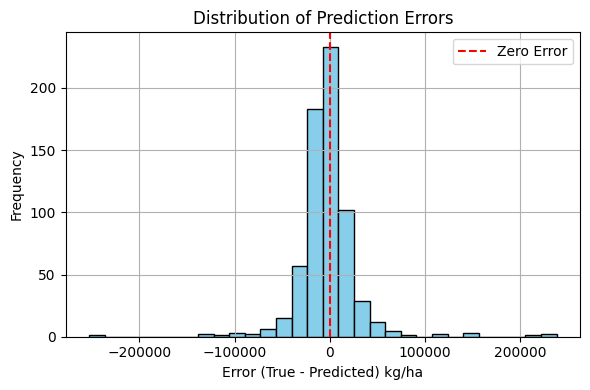

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Compute prediction errors
errors = y_true.flatten() - y_pred.flatten()

# Plot the error histogram
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (True - Predicted) kg/ha")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('error_histogram.png')
plt.show()

## Scatter plot Predicted vs True

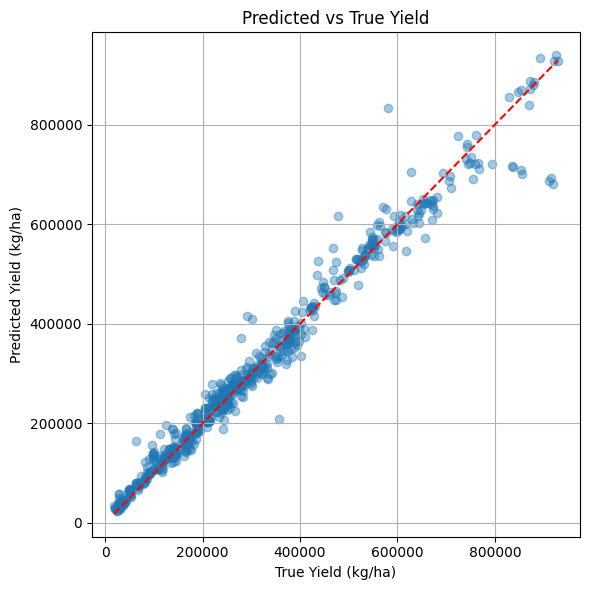

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True Yield (kg/ha)")
plt.ylabel("Predicted Yield (kg/ha)")
plt.title("Predicted vs True Yield")
plt.grid(True)
plt.tight_layout()
plt.savefig('predicted_vs_true.png')
plt.show()

## Save model outputs for the test set 

In [114]:
import pandas as pd

# flatten the arrays
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# create DataFrame
results_df = pd.DataFrame({
    "true_yield": y_true_flat,
    "predicted_yield": y_pred_flat
})

# save to CSV
results_df.to_csv("test_predictions.csv", index=False)